In [26]:
import os
import datetime

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("../../data/weather_data/3316_crosby_weather_data.parquet")

In [3]:
df.head()

,location_id,day,minutes_after_midnight,temperature,weather,humidity,wind_direction,wind_gust,wind_speed,pressure,visibility,dew_point
0,3316,2024-01-26Z,1140,7.0,0,76.8,SW,19,16,1029,14000,3.3
1,3316,2024-01-26Z,1200,6.7,0,77.4,SSW,22,14,1030,15000,3.1
2,3316,2024-01-26Z,1260,6.9,2,78.0,SSW,25,15,1030,14000,3.4
3,3316,2024-01-26Z,1320,8.0,5,74.9,SW,21,13,1030,11000,3.9
4,3316,2024-01-26Z,1380,7.3,5,78.7,SSW,19,14,1030,4700,3.9


In [4]:
df.isna().any()

location_id               False
day                       False
minutes_after_midnight    False
temperature               False
weather                   False
humidity                  False
wind_direction             True
wind_gust                  True
wind_speed                 True
pressure                  False
visibility                False
dew_point                 False
dtype: bool

In [5]:
pd.concat(
    [
        df["wind_direction"].isna().value_counts().to_frame(),
        df["wind_gust"].isna().value_counts().to_frame(),
        df["wind_speed"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "wind_direction", 1: "wind_gust", 2: "wind_speed"})

,wind_direction,wind_gust,wind_speed
False,1733,1733,1733
True,3,3,3


In [6]:
df.loc[(df["wind_direction"].isna()) | (df["wind_gust"].isna()), :]

,location_id,day,minutes_after_midnight,temperature,weather,humidity,wind_direction,wind_gust,wind_speed,pressure,visibility,dew_point
937,3316,2024-03-07Z,660,8.5,7,73.5,None,None,None,1022,14000,4.1
938,3316,2024-03-07Z,720,9.9,3,66.3,None,None,None,1022,15000,4.0
939,3316,2024-03-07Z,780,10.1,7,62.2,None,None,None,1021,15000,3.3


In [7]:
df.dtypes

location_id               object
day                       object
minutes_after_midnight    object
temperature               object
weather                   object
humidity                  object
wind_direction            object
wind_gust                 object
wind_speed                object
pressure                  object
visibility                object
dew_point                 object
dtype: object

In [8]:
df["day"] = df["day"].apply(lambda x: x.replace("Z", ""))

In [9]:
date_cols = "day"
str_cols = ["wind_speed", "wind_direction"]
numeric_cols = [col for col in df.columns if col not in date_cols and col not in str_cols] 
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
# df[date_cols] = df[date_cols].apply(pd.to_datetime)

df.dtypes

location_id                 int64
day                        object
minutes_after_midnight      int64
temperature               float64
weather                     int64
humidity                  float64
wind_direction             object
wind_gust                 float64
wind_speed                 object
pressure                    int64
visibility                  int64
dew_point                 float64
dtype: object

In [11]:
df.head()

,location_id,day,minutes_after_midnight,temperature,weather,humidity,wind_direction,wind_gust,wind_speed,pressure,visibility,dew_point
0,3316,2024-01-26,1140,7.0,0,76.8,SW,19.0,16,1029,14000,3.3
1,3316,2024-01-26,1200,6.7,0,77.4,SSW,22.0,14,1030,15000,3.1
2,3316,2024-01-26,1260,6.9,2,78.0,SSW,25.0,15,1030,14000,3.4
3,3316,2024-01-26,1320,8.0,5,74.9,SW,21.0,13,1030,11000,3.9
4,3316,2024-01-26,1380,7.3,5,78.7,SSW,19.0,14,1030,4700,3.9


In [12]:
df["hour"] = (df['minutes_after_midnight']/60).astype(int)

In [19]:
df["hour_number"] = (df['minutes_after_midnight']/60).astype(int)
df["hour"] = (df["hour_number"]).apply(
    lambda x: str(datetime.timedelta(hours=x))
)

df["date"] = pd.to_datetime(
    (df["day"] + " " + df["hour"])
)

df.set_index("date", inplace=True)
df.sample(n=5)

,location_id,day,minutes_after_midnight,temperature,weather,humidity,wind_direction,wind_gust,wind_speed,pressure,visibility,dew_point,hour,hour_number
date,,,,,,,,,,,,,,
2024-03-29 20:00:00,3316,2024-03-29,1200,9.2,8,78.4,S,24.0,19,985,50000,5.6,20:00:00,20
2024-03-25 17:00:00,3316,2024-03-25,1020,9.1,12,86.2,ESE,17.0,8,994,26000,6.9,17:00:00,17
2024-03-11 11:00:00,3316,2024-03-11,660,7.6,8,81.7,ESE,9.0,5,1009,11000,4.7,11:00:00,11
2024-04-03 02:00:00,3316,2024-04-03,120,8.7,12,94.1,E,17.0,8,995,7000,7.8,2:00:00,2
2024-02-21 02:00:00,3316,2024-02-21,120,9.4,5,96.6,SSE,19.0,13,1012,22000,8.9,2:00:00,2


<Axes: xlabel='date'>

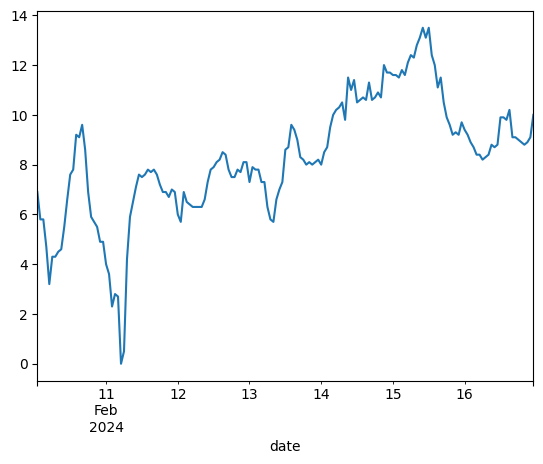

In [28]:
df.loc[(df.index > "02-10-2024") & (df.index < "02-17-2024")]["temperature"].plot()